## December 4, 2019 - An Evolutionary Algorithm for the TSP
The goal of this exercise is to showcase how easy it is to implement an evolutionary algorithm from scratch for the traveling salesperson problem (TSP) and understand its basic working principles and their influence on the algorithm performance.

In [1]:
# implementation of an EA for the TSP
#
# Please note that this is just one example:
# many other implementations will work as well.
#
from __future__ import division, print_function
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def placeCitiesRandomly(n, xmax, ymax):
    """
        Returns a (n x 2)-dimensional numpy.array of n city
        coordinates (x,y), randomly chosen on an integer grid
        [0, xmax] x [0, ymax].
    """
    return np.array([np.random.randint(0, xmax+1, n), np.random.randint(0, ymax+1, n)])

In [3]:
def getDistances(cities):
    """ 
        Returns a distance matrix with the symmetric
        pairwise Euclidean distances between the n
        cities in the 2-dimensional nunmpy.array `cities`
        (with the cities' x and y coordinates given as columns)
    """
    n = cities.shape[1] # number of cities
    D = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            D[i][j] = np.sqrt((cities[0][i] - cities[0][j])**2 + (cities[1][i] - cities[1][j])**2)

    return D

In [4]:
def f_TSP(permutation, D):
    """ Returns the length of the TSP tour
        through all cities in the order
        given in permutation, when the
        distances between the cities are
        given as in the symmetric distance
        matrix D.
        
        >>> n = 5
        >>> cities = np.array([[ 7, 2,  3,  7,  7], [ 1,  8,  8, 14, 38]])
        >>> dists = getDistances(cities)
        >>> solution1 = [1, 4, 3, 2, 0]
        >>> f_TSP(solution1, dists)
        78.2894982178
        
    """
    tourlength = 0
    for i in range(len(permutation)-1):
        tourlength = tourlength + D[permutation[i]][permutation[i+1]]
    tourlength = tourlength + D[permutation[-1]][permutation[0]]
    
    return tourlength

In [5]:
def plotSolution(permutation, cities, fvalue):
    """
        Plots a solution to the TSP, given by the
        permutation and the placement of cities.
        Furthermore, the current function value
        is plotted as well.
    """
    plt.plot(cities[0], cities[1], 'ro')
    plt.plot(cities[0][permutation], cities[1][permutation], 'b-')
    plt.plot([cities[0][permutation[-1]], cities[0][permutation[0]]],
             [cities[1][permutation[-1]], cities[1][permutation[0]]], 'b-')
    plt.xlim(-0.1, xmax+0.1)
    plt.ylim(-0.1, ymax+0.1)
    plt.text(0, 0, 'f= ' + str(fvalue))
    plt.show()

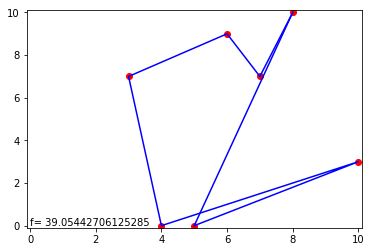

In [6]:
# testing:
n = 7
xmax = 10
ymax = 10
cities = placeCitiesRandomly(n, xmax, ymax)
dists = getDistances(cities)
solution1 = [1, 4, 3, 2, 0, 5, 6]
ff = f_TSP(solution1, dists)
plotSolution(solution1, cities, ff)

In [7]:
def init_population(mu, n):
    """ returns mu random permutations of S(n) as a list of numpy.arrays """
    
    perms = []
    for i in range(mu):
        # get a random permuation by sorting a random vector:
        p = (np.random.rand(n)).argsort()
        # equivalent: p = np.random.permutation(n)
        perms.append(p)
        
    return perms

In [8]:
def mutate_swap(parent):
    """
        Mutates the given parent permutation by swapping
        two random cities.
    """
    offspring = parent
    # sample the two indices to swap:
    frm = np.random.randint(len(offspring))
    to = np.random.randint(len(offspring))
    # swap those indices in one line:
    offspring[frm], offspring[to] = offspring[to], offspring[frm] 
    return offspring

In [9]:
def order_xover(parent1, parent2):
    """ 
        Creates two children from the two given
        parent permuations by order 1 crossover.
    """

    n = len(parent1)
    child1 = -1 * np.ones(n, dtype=int)
    child2 = -1 * np.ones(n, dtype=int)
    
    # randomly pick the crossover points
    i = np.random.randint(0, n-1)
    j = np.random.randint(i, n)

    # copy middle parts from parents:
    for k in range(i, j+1):
        child1[k] = parent1[k]
        child2[k] = parent2[k]
    
    # copy remaining cities from the other parent,
    # starting from index j+1:
    k1 = np.nonzero(parent2==child1[j])[0][0]
    k2 = np.nonzero(parent1==child2[j])[0][0]
    
    idx = j
    while idx < n-1: # fill first the right part
        idx = (idx + 1) % n
        while parent2[k1] in child1:
            k1 = (k1 + 1) % n
        while parent1[k2] in child2:
            k2 = (k2 + 1) % n
        child1[idx] = parent2[k1]
        child2[idx] = parent1[k2]
        
    idx = -1
    while idx < i-1: # fill first the right part
        idx = idx + 1
        while parent2[k1] in child1:
            k1 = (k1 + 1) % n
        while parent1[k2] in child2:
            k2 = (k2 + 1) % n
        child1[idx] = parent2[k1]
        child2[idx] = parent1[k2]
    
    # note: the last two while loops obviously
    #       contain duplicate code and can
    #       be put together into one ("exercise!")
    
    return (child1, child2)
    
    

In [10]:
def my_evolutionary_algorithm(cities, dists, maxbudget):
    """ Runs a simple elitist Evolutionary Algorithm
    for the TSP. Cities and dists are thereby
    indicating the x-y coordinates of the cities and 
    their Euclidian distances and maxbudget gives
    the maximal number of function evaluations performed.
    
    Returns a vector of function values in which for each
    evaluation time, the best-so-far function value is stored.
    In addition, the algorithm returns the best ever observed
    function value and the corresponding search point as a 
    permutation of the given cities.
    """

    # internal parameters:
    mu = 10 # population size
    lam = 10 # number of offspring (shall be even if crossover is used)
    mutation_prob = 1

    # Initialization:
    n = len(cities[0])
    best_so_far = [] # store best so far f-values
    population = init_population(mu, n)
    f_population = []  # store f-values of population here
    for p in population:
        f_population.append(f_TSP(p, dists))
    num_f_evals = mu
    
    while num_f_evals < maxbudget:
        # Random mating selection and swap mutation:
        offspring = []  # store the offspring temporarily
        f_offspring = []  # also their f-values
        for i in range(lam // 2):
            # choose parents randomly (*with* replacement here!):
            p1 = population[np.random.randint(len(population))]
            p2 = population[np.random.randint(len(population))]
            (child1, child2) = order_xover(p1, p2)
            
            if np.random.rand() < mutation_prob:
                offspring.append(mutate_swap(child1))
                offspring.append(mutate_swap(child2))
            else:
                offspring.append(child1)
                offspring.append(child2)
                
            # evaluate and store:    
            f_offspring.append(f_TSP(child1, dists))
            f_offspring.append(f_TSP(child2, dists))
            num_f_evals = num_f_evals + 2
        
        # Environmental selection:
        for i, o in enumerate(offspring):
            population.append(o)
            f_population.append(f_offspring[i])
        # sorting of both parent and offspring...
        idx = np.array(f_population).argsort()  # index according to sorting f-values
    
        # move temporarily to numpy arrays...
        population = np.array(population)
        f_population = np.array(f_population)
        
        population = population[idx]
        f_population = f_population[idx]
        # selecting best mu:
        population = population[0:mu]
        f_population = f_population[0:mu]
        
        # always plot best found solution:
        plotSolution(population[0], cities, f_population[0])
        best_so_far.append(f_population[0])
        
        # move back to lists...
        population = list(population)
        f_population = list(f_population)
    
    return (best_so_far, f_population[0], population[0])

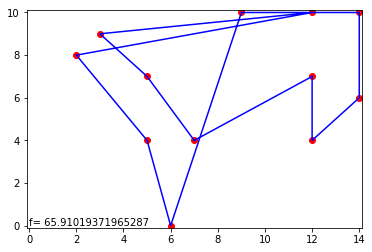

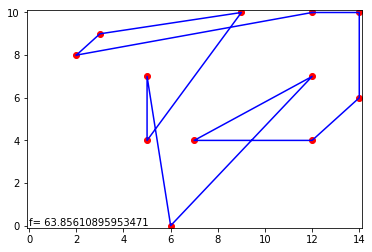

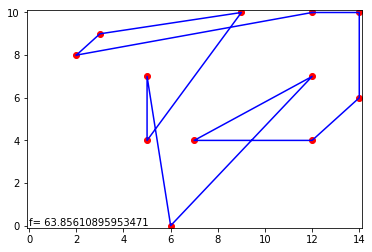

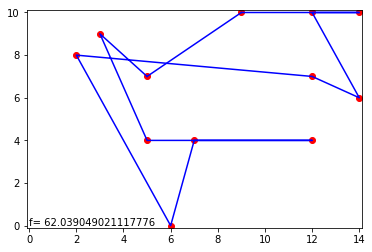

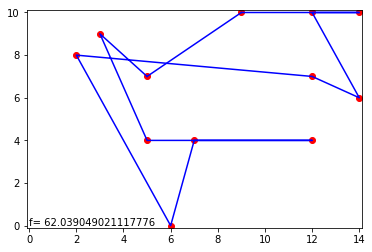

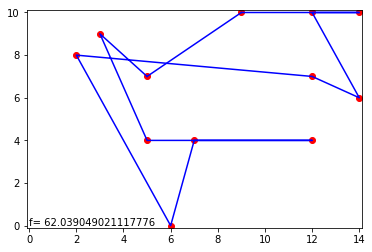

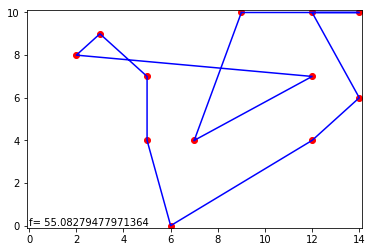

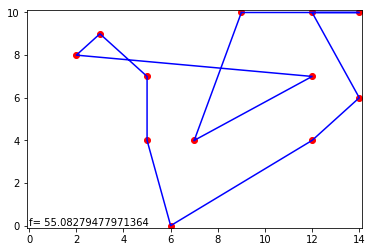

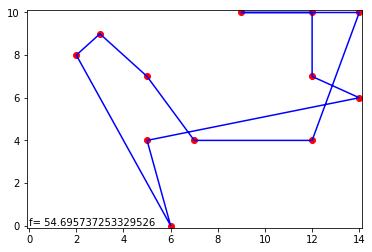

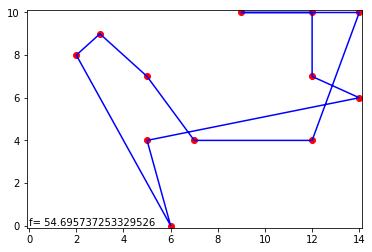

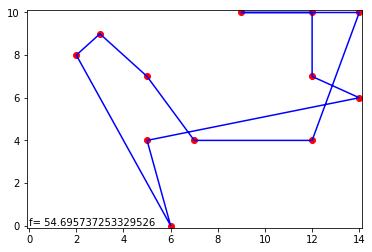

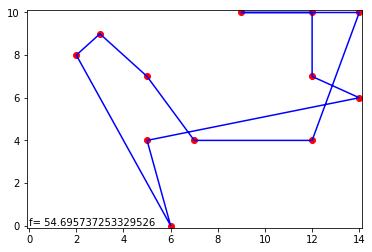

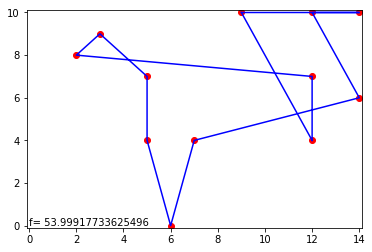

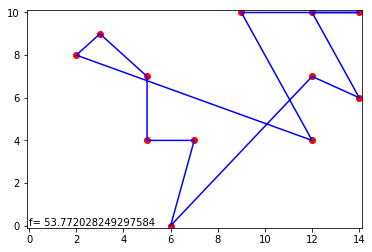

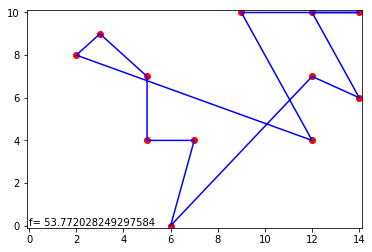

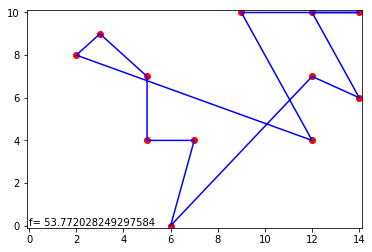

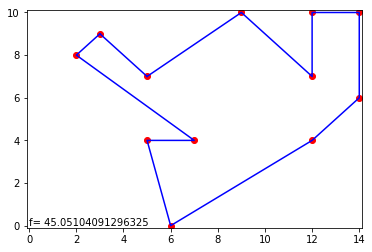

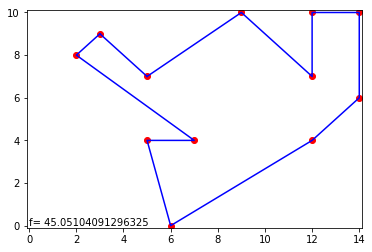

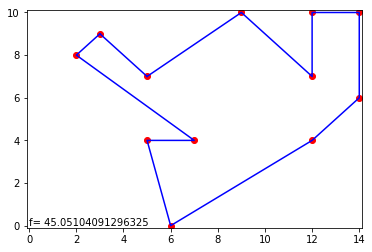

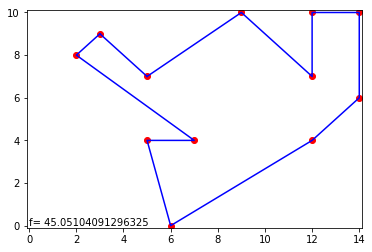

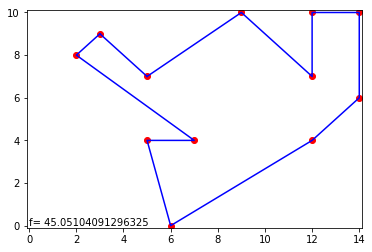

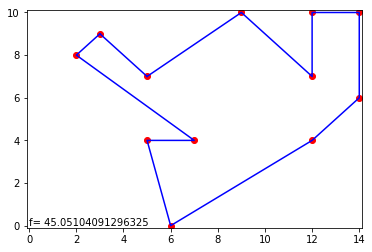

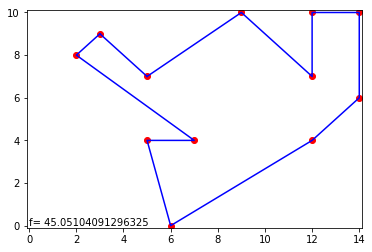

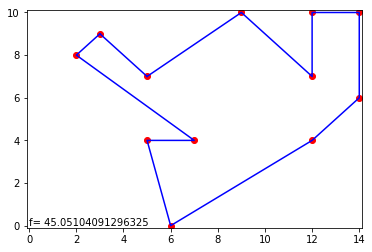

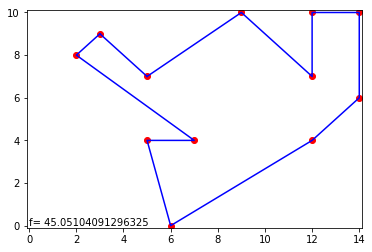

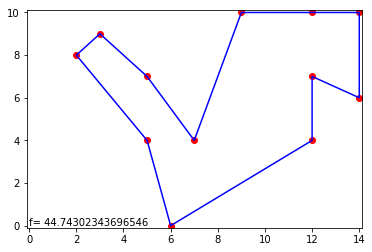

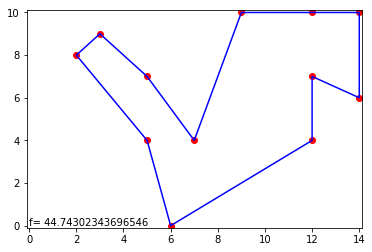

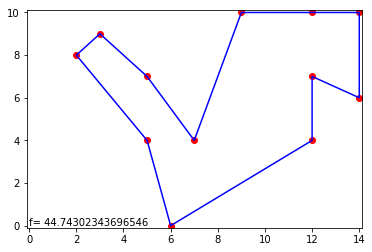

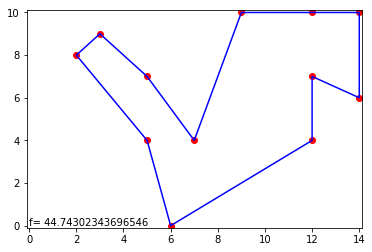

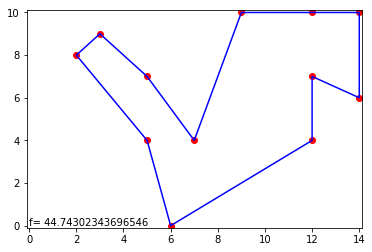

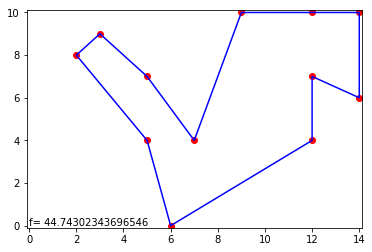

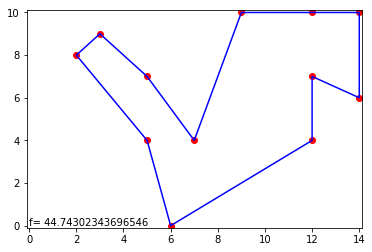

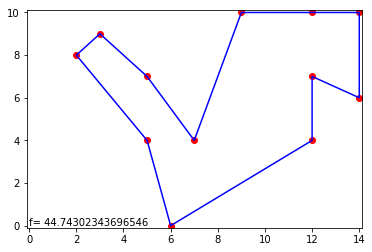

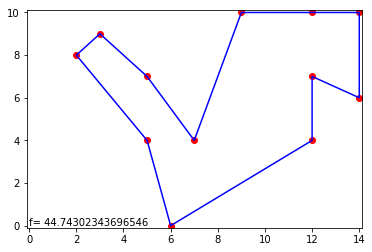

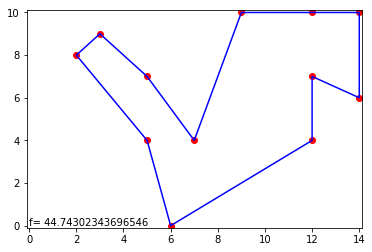

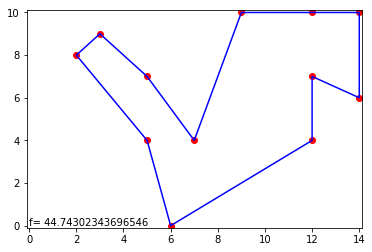

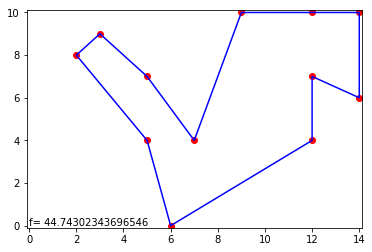

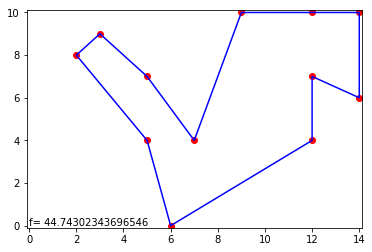

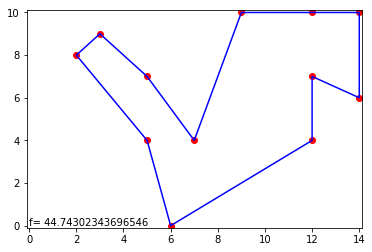

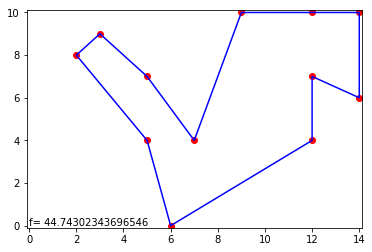

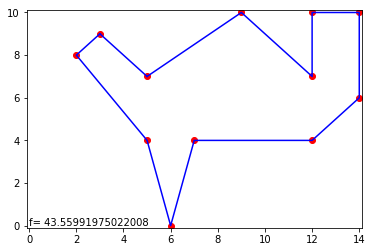

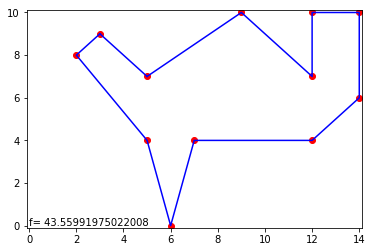

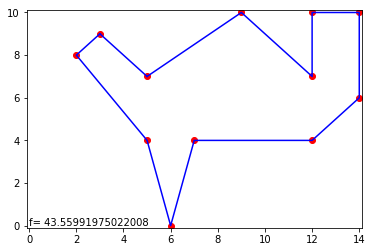

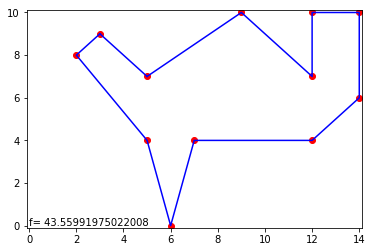

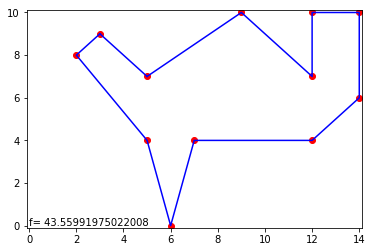

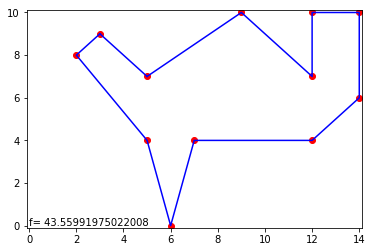

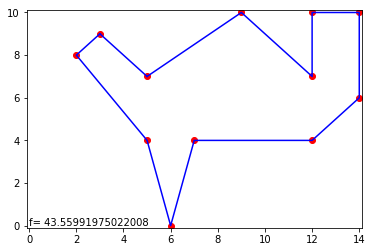

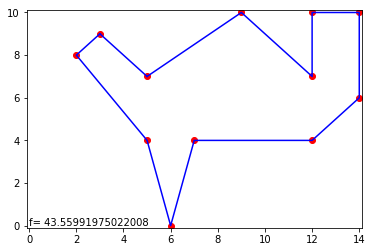

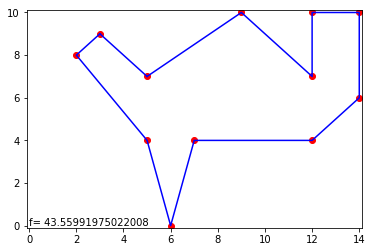

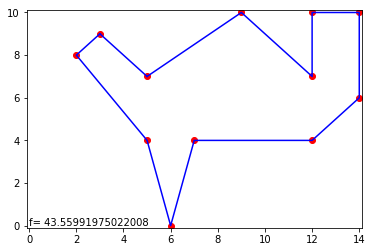

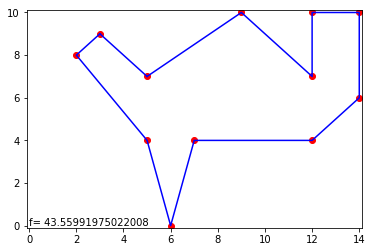

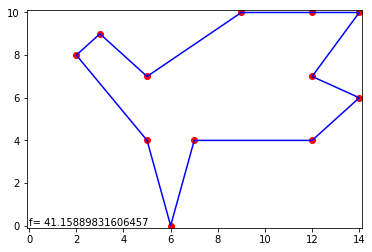

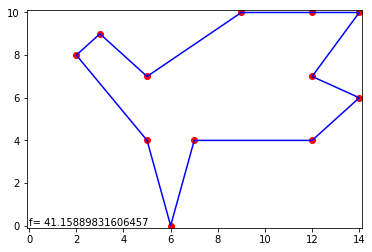

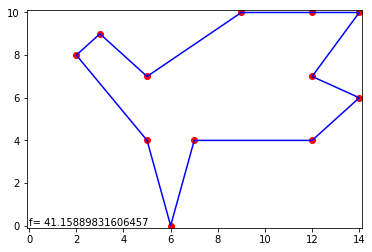

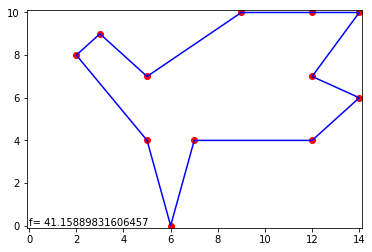

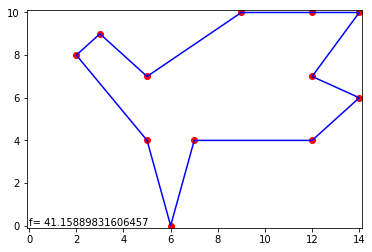

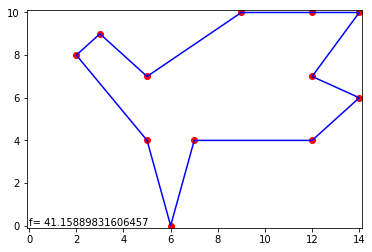

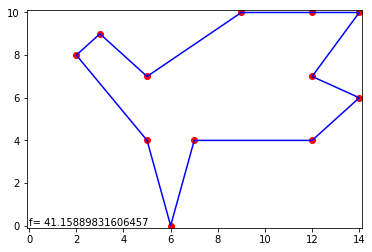

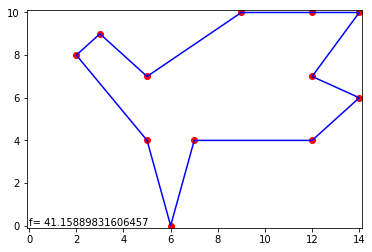

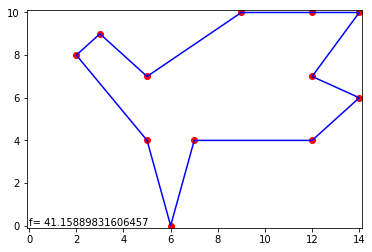

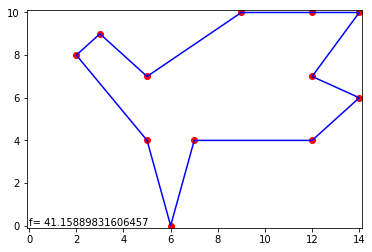

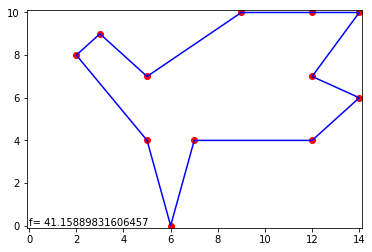

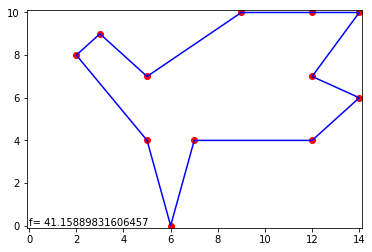

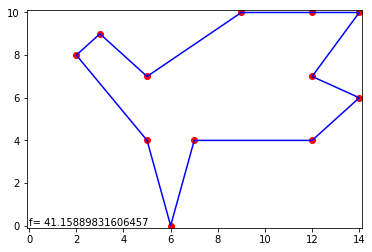

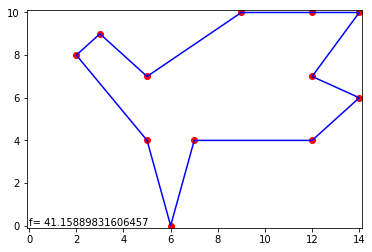

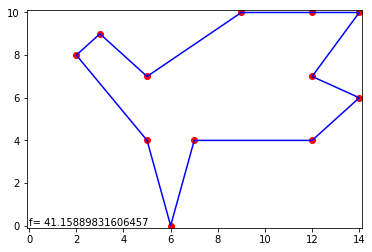

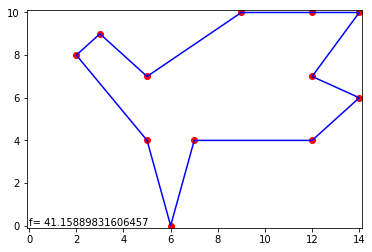

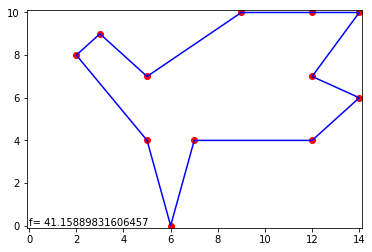

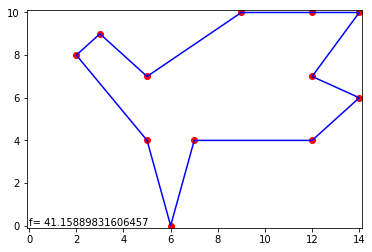

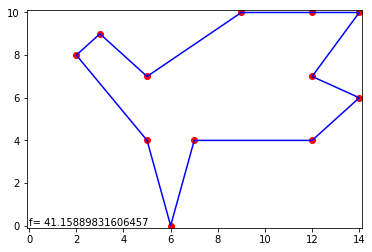

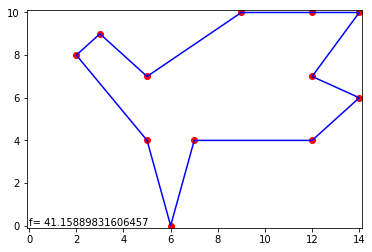

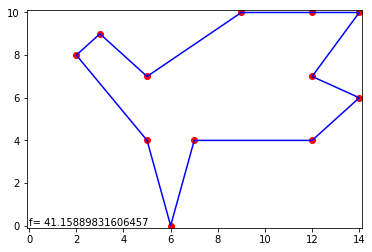

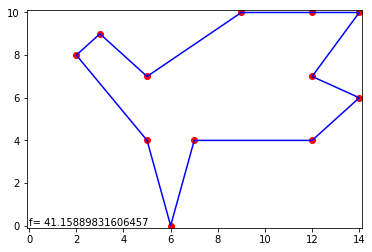

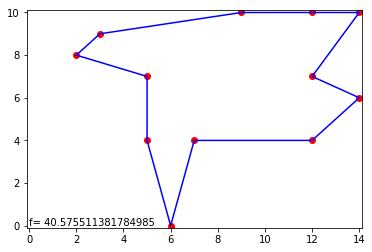

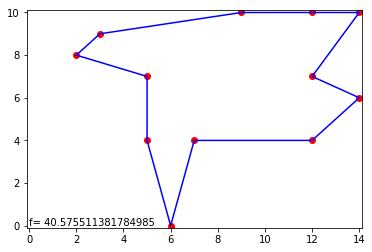

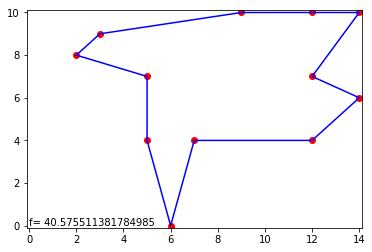

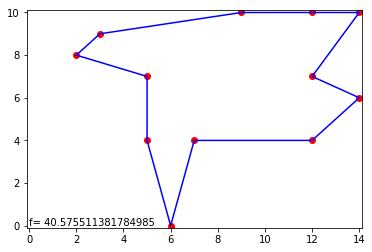

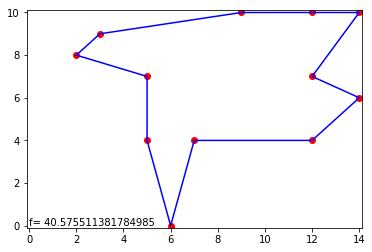

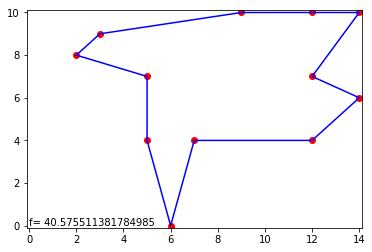

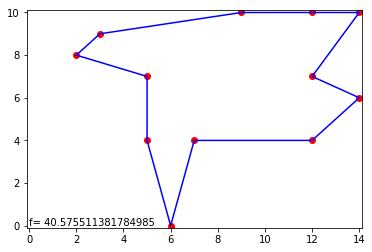

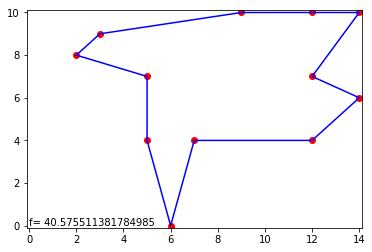

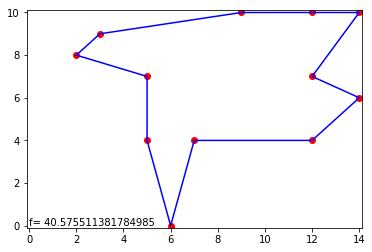

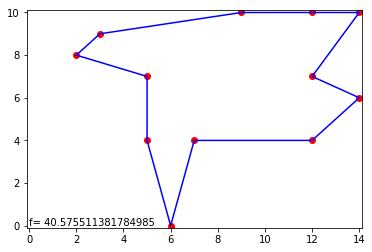

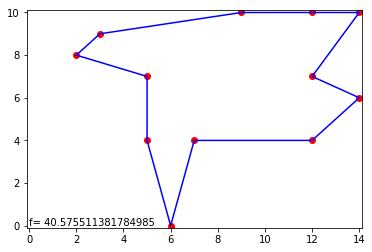

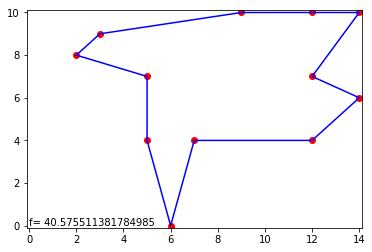

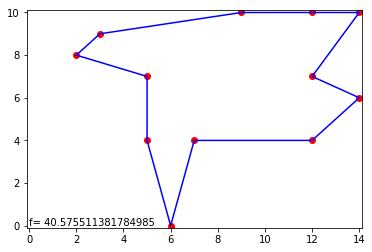

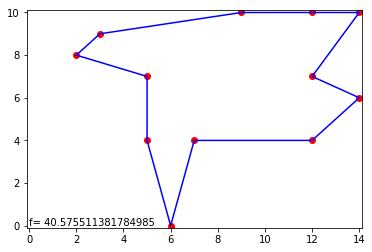

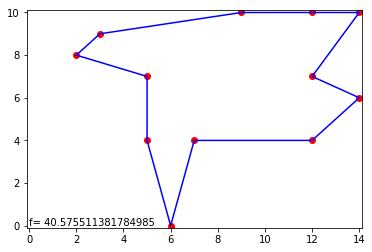

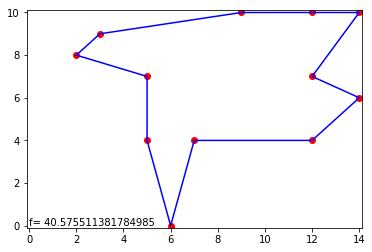

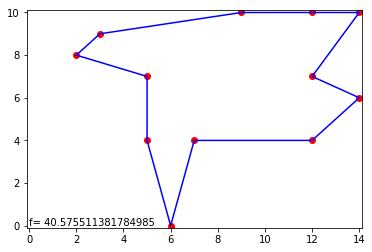

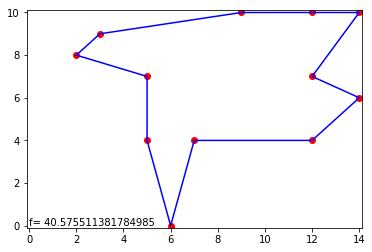

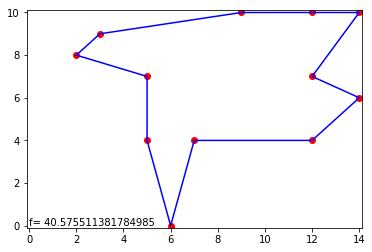

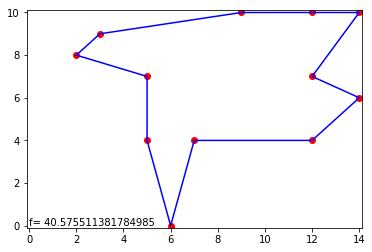

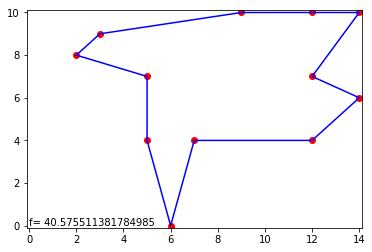

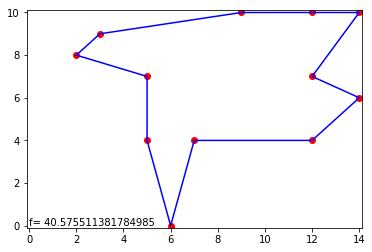

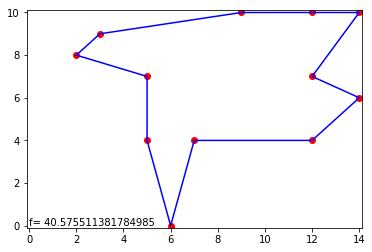

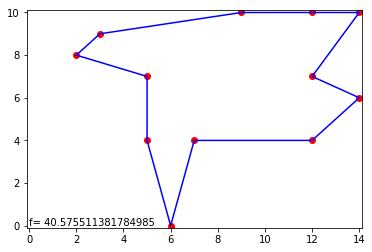

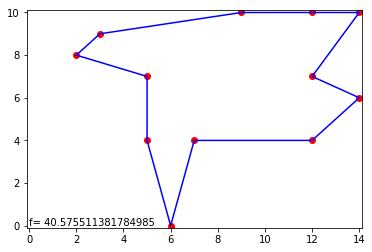

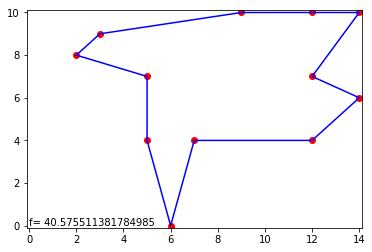

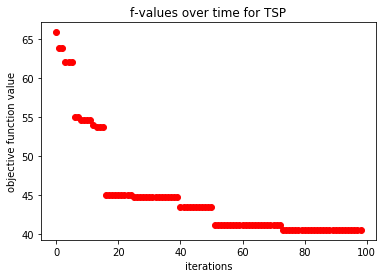

In [13]:
# example call of the EA:
n = 12  # number of cities
xmax = 14
ymax = 10
cities = placeCitiesRandomly(n, xmax, ymax)
dists = getDistances(cities)
(best_so_far, f_best, best) = my_evolutionary_algorithm(cities, dists, 1000)

plt.figure(999)
plt.plot(range(len(best_so_far)), best_so_far, 'ro')
plt.title('f-values over time for TSP')
plt.xlabel('iterations')
plt.ylabel('objective function value')
plt.show()

